<h1><p style="text-align: center;"> Final Term (Assignment-2)</p></h1>
<h3><p style="text-align: center;">NAME: REZUAN ISLAM </p></h3>
<h3><p style="text-align: center;">ID: 20-43691-2 </p></h3>

### Importing all necessary packages

In [1]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping
import glob as gb
import scipy
import random
import seaborn as sns
import os
from PIL import Image
from tqdm import tqdm
import cv2
import numpy as np
import matplotlib.pyplot as plt


### Resize the images and assign the dataset directory path

In [2]:
resize = 224
learning_rate = 1e-4
seed = 107

INIT_LR = 1e-4
EPOCHS = 17
BS = 64

dir_mask = "./mask_dataset/with_mask/"
dir_inc_mask = "./mask_dataset/mask_weared_incorrect/"
dir_nomask = "./mask_dataset/without_mask/"
TRAIN_DIR = "./mask_dataset"

assert os.path.exists(dir_mask), "Could not find" + dir_mask
assert os.path.exists(dir_inc_mask), "Could not find" + dir_inc_mask
assert os.path.exists(dir_nomask), "Could not find" + dir_nomask

### Categories the dataset and print it in a chart

100%|██████████| 3/3 [00:00<00:00, 54.29it/s]


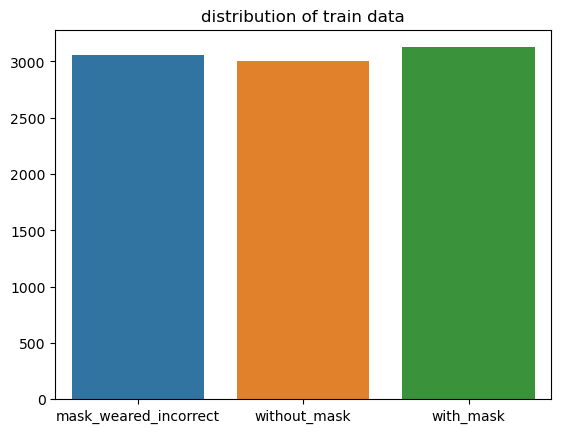

9189


100%|██████████| 3126/3126 [01:47<00:00, 29.15it/s]


In [3]:
categories = []
class_count = []
train_exm = 0

for f in tqdm(os.listdir(TRAIN_DIR)):
    files = gb.glob(pathname=str(TRAIN_DIR + "//" + f + "/*"))
    categories.append(f)
    class_count.append(len(files))
    train_exm += len(files)

sns.barplot(x=categories, y=class_count).set_title("distribution of train data")
plt.show()
print(train_exm)

data = []
labels = []

for c in categories:
    path = os.path.join(TRAIN_DIR, c)
    for img in tqdm(os.listdir(path)):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(resize, resize))
        image = img_to_array(image)
        image = preprocess_input(image)

        data.append(image)
        labels.append(c)

data = np.array(data, dtype="float32")
labels = np.array(labels)

In [4]:
len(labels)


9189

In [5]:
unique, counts = np.unique(labels, return_counts=True)
dict(zip(unique, counts))


{'mask_weared_incorrect': 3058, 'with_mask': 3126, 'without_mask': 3005}

In [6]:
lb = LabelEncoder()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
labels

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

In [7]:
AugmentedData = ImageDataGenerator(
    zoom_range=0.1,
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest",
)

### Train the model

In [8]:
baseModel = MobileNetV2(
    weights="imagenet", include_top=False, input_shape=(224, 224, 3)
)
baseModel.summary()

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(256, activation="relu")(headModel)
headModel = Dropout(0.25)(headModel)
headModel = Dense(3, activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
    layer.trainable = False

9406464/9406464 [==============================] - 4s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReL

In [9]:
(trainX, testX, trainY, testY) = train_test_split(
    data, labels, test_size=0.2, stratify=labels, random_state=42
)
print(f"Shape of x_train: {trainX.shape}")
print(f"Shape of y_train: {trainY.shape}")
print()
print(f"Shape of x_test: {testX.shape}")
print(f"Shape of y_test: {testY.shape}")

Shape of x_train: (7351, 224, 224, 3)
Shape of y_train: (7351, 3)

Shape of x_test: (1838, 224, 224, 3)
Shape of y_test: (1838, 3)


In [10]:
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

print(
    """[INFO] compiling model...
[INFO] training head..."""
)

H = model.fit(
    AugmentedData.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS,
) 

[INFO] compiling model...
[INFO] training head...
Epoch 1/17
114/114 [==============================] - 456s 4s/step - loss: 0.4534 - accuracy: 0.8178 - val_loss: 0.3426 - val_accuracy: 0.8640
Epoch 2/17
114/114 [==============================] - 361s 3s/step - loss: 0.2157 - accuracy: 0.9230 - val_loss: 0.2903 - val_accuracy: 0.8803
Epoch 3/17
114/114 [==============================] - 357s 3s/step - loss: 0.1699 - accuracy: 0.9410 - val_loss: 0.2424 - val_accuracy: 0.9037
Epoch 4/17
114/114 [==============================] - 349s 3s/step - loss: 0.1453 - accuracy: 0.9483 - val_loss: 0.1905 - val_accuracy: 0.9184
Epoch 5/17
114/114 [==============================] - 315s 3s/step - loss: 0.1320 - accuracy: 0.9535 - val_loss: 0.1791 - val_accuracy: 0.9227
Epoch 6/17
114/114 [==============================] - 390s 3s/step - loss: 0.1209 - accuracy: 0.9586 - val_loss: 0.1591 - val_accuracy: 0.9336
Epoch 7/17
114/114 [==============================] - 331s 3s/step - loss: 0.1090 - accuracy

### Traning and Validation -> Accuracy and Loss

[INFO] evaluating network...
29/29 [==============================] - 58s 2s/step
              precision    recall  f1-score   support

           0       0.99      0.90      0.94       612
           1       0.90      0.98      0.94       625
           2       0.97      0.97      0.97       601

    accuracy                           0.95      1838
   macro avg       0.95      0.95      0.95      1838
weighted avg       0.95      0.95      0.95      1838



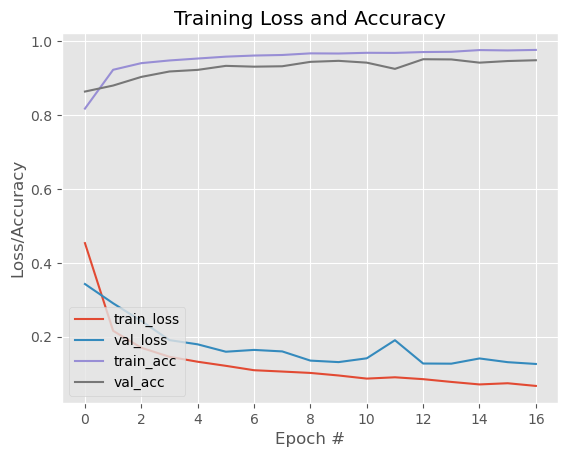

In [11]:
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

predIdxs = np.argmax(predIdxs, axis=1)

print(classification_report(testY.argmax(axis=1), predIdxs))

N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

In [12]:
model.save("my_mask_detector_1.model", save_format="h5")


c:\Users\rezua\anaconda3\envs\cvpr\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


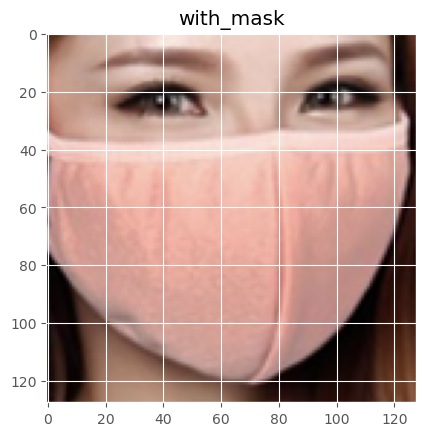

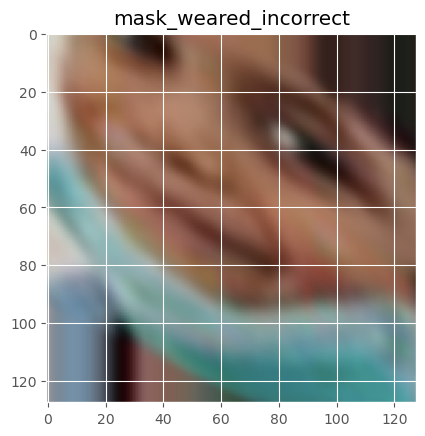

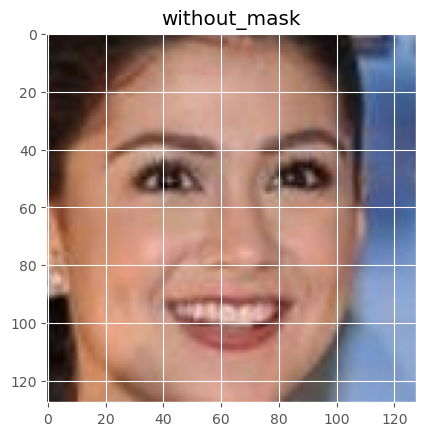

In [19]:
image01 = Image.open("/.Summer_22-23   10th/CVPR/Face mask detection/mask_dataset/with_mask/36.png")
image02 = Image.open("/.Summer_22-23   10th/CVPR/Face mask detection/mask_dataset/mask_weared_incorrect/49.png")
image03 = Image.open("/.Summer_22-23   10th/CVPR/Face mask detection/mask_dataset/without_mask/19.png")

plt.figure("image01")
plt.title("with_mask")
plt.imshow(image01)

plt.figure("image02")
plt.title("mask_weared_incorrect")
plt.imshow(image02)

plt.figure("image03")
plt.title("without_mask")
plt.imshow(image03)

In [22]:
image01 = cv2.resize(
    cv2.imread(
        "/.Summer_22-23   10th/CVPR/Face mask detection/mask_dataset/with_mask/36.png"
    ),
    (resize, resize),
)
image01 = image01.astype("float") / 255.0
image01 = image01.reshape((1, image01.shape[0], image01.shape[1], image01.shape[2]))

image02 = cv2.resize(
    cv2.imread(
        "/.Summer_22-23   10th/CVPR/Face mask detection/mask_dataset/mask_weared_incorrect/49.png"
    ),
    (resize, resize),
)
image02 = image02.astype("float") / 255.0
image02 = image02.reshape((1, image02.shape[0], image02.shape[1], image02.shape[2]))

image03 = cv2.resize(
    cv2.imread(
        "/.Summer_22-23   10th/CVPR/Face mask detection/mask_dataset/without_mask/19.png"
    ),
    (resize, resize),
)
image03 = image03.astype("float") / 255.0
image03 = image03.reshape((1, image03.shape[0], image03.shape[1], image03.shape[2]))


labelz = ("mask_weared_incorrect", "with_mask", "without_mask")

predict = model.predict(image01, verbose=1)
i = predict.argmax(axis=1)[0]
print(labelz[i])

predict = model.predict(image02, verbose=1)
i = predict.argmax(axis=1)[0]
print(labelz[i])

predict = model.predict(image03, verbose=1)
i = predict.argmax(axis=1)[0]
print(labelz[i])

1/1 [==============================] - 0s 66ms/step
with_mask
1/1 [==============================] - 0s 64ms/step
mask_weared_incorrect
1/1 [==============================] - 0s 60ms/step
with_mask
